## Random Forest Classifiers

<img style="float: l;" src="./images/wisdom.png" width="300px">

#### Ensemble Prediction Method
<BR>
<img align="left" style="float: l;" src="./images/random-forest-vote.png" width="400px">

<img align="center" style="float: l;" src="./images/random-forest-bagging.png" width="500px">

#### Understanding Bias versus Variance

<img align="left" style="float: l;" src="./images/bias-variance.png" width="500px">

<img style="float: l;" src="./images/model-complexity.png" width="450px">

<BR>
<BR>

##### What does intuition tell you is better to mimimize - bias or variance ?

##### Minimize <U><B><I>bias</I></B></U> becuase over time the law of averages kick in, right?

##### Wrong!!
* We do not have infinite data, typically a modest training set !
* Performance is measured on the data that we have.

###### Does randomly selecting a small number of features at each split point effect performance ?
Suppose for a classification problem the feature space was such that there were 6 relevant features and 100 irrelevant (noise) features. Assuming $m\space =\space \sqrt{(6+100)}≈10$ random features at every split point what is the probability of getting a relevant feature at every split point?



                                           
### Environment Setup

In [7]:
import re
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
%matplotlib inline 
import matplotlib.pyplot as plt

### Syntatic NLP Processing

#### We will define some Python functions that will perform some syntatic work on our corpus. 

In [8]:
def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [ token for token in tokens if re.search('(^[a-zA-Z]+$)', token) ]
    return filtered_tokens

cachedStopWords = stopwords.words("english") + ['year', 'old', 'man', 'woman', 'ap', 'am', 'pm', 'portable', 'pa', 'lat', 'admitting', 'diagnosis', 'lateral']


### Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.  

In [9]:
file = open('differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()
corpusList = list(corpus.values())
labels = list(corpus.keys())

### Generate Document-Term Frequency Counts

#### In this step we tokenize our text and remove stop words in addition to generating our frequency counts.

#### 1) How many documents are we working with and how many features (unigrams & bigrams)?

#### 2) Can you figure out what max_df and min_df is doing to our feature count?

In [10]:
cv = CountVectorizer(lowercase=True, max_df=0.80, max_features=None, min_df=0.033,
                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
X = cv.fit_transform(corpusList)
print(X.shape)
print()
lexicon = cv.get_feature_names()
print (lexicon)
print()

(1500, 773)

['abd', 'abdomen', 'abdomen contrast', 'abdomen pelvis', 'abdominal', 'abnormalities', 'acquired', 'acute', 'acute sob', 'addition', 'adjacent', 'administered', 'administration', 'adrenal', 'adrenal glands', 'air', 'air space', 'airspace', 'allowing', 'along', 'also', 'also noted', 'although', 'alveolar', 'amount', 'amt', 'amt final', 'amt underlying', 'angle', 'anterior', 'aorta', 'aortic', 'aortic stenosis', 'apex', 'apical', 'apices', 'appear', 'appearance', 'appears', 'approximately', 'approximately cm', 'area', 'areas', 'arrest', 'arteries', 'artery', 'ascites', 'aspect', 'aspiration', 'assess', 'associated', 'atelectasis', 'atelectasis left', 'atrial', 'atrium', 'attenuation', 'available', 'axial', 'axial images', 'axillary', 'base', 'bases', 'basilar', 'bibasilar', 'bilateral', 'bilateral pleural', 'bilateral pulmonary', 'bilaterally', 'bladder', 'bleed', 'blunting', 'bone', 'bone windows', 'bowel', 'breath', 'c', 'ca', 'cabg', 'cad', 'cad chf', 'calcification', 'ca

### Construct our Classes

#### We need to assign a class for each classification. We typically assign numeric values to classes.

In [11]:
Y = []
for key in corpus:        
    if (key.startswith('COPD') or key.startswith('CHF')):
        Y.append(0)
    elif (key.startswith('PNA')):
        Y.append(1)
Y = np.array(Y)

### Let's Run It!

#### We will generate models and evaluate the modes using bootstrapping.

In [12]:
results = []
cont = []
kf = KFold(n_splits=10, shuffle=True)
trees = [11, 51, 101, 201, 301, 401, 501]
for t in range(len(trees)):
    fold = 1
    truth = []
    rf_prediction = []
    print("model ", t, ": Random Forest trees = " + str(trees[t]))
    test_count = 0
    rf = RandomForestClassifier(n_estimators=trees[t], criterion='entropy', n_jobs=-1, )
    for train_idx, test_idx in kf.split(X):
        trainX = X[train_idx]
        trainY = Y[train_idx]
        testX = X[test_idx]
        testY = Y[test_idx]
        truth.append(testY)
        rf.fit(trainX, trainY)
        Y_hat = rf.predict(testX)
        rf_prediction.append(Y_hat)
        print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
        fold += 1
    truth = np.concatenate(truth, axis=0)    
    rf_prediction = np.concatenate(rf_prediction, axis=0)
    test_results = np.sum(rf_prediction == truth)/len(truth)
    print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
    rf = rf.fit(X, Y)
    Y_hat = rf.predict(X)
    train_results = np.sum(Y_hat == Y)/len(Y)
    print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
    results.append([train_results, test_results])   
    cont.append([truth, rf_prediction])



model  0 : Random Forest trees = 11
   Fold 1 accuracy: 94.67 %
   Fold 2 accuracy: 93.33 %
   Fold 3 accuracy: 89.33 %
   Fold 4 accuracy: 91.33 %
   Fold 5 accuracy: 93.33 %
   Fold 6 accuracy: 93.33 %
   Fold 7 accuracy: 96.00 %
   Fold 8 accuracy: 94.00 %
   Fold 9 accuracy: 96.67 %
   Fold 10 accuracy: 97.33 %
     Overall test accuracy: 93.93 %
     Overall training accuracy: 99.87 %
model  1 : Random Forest trees = 51
   Fold 1 accuracy: 92.67 %
   Fold 2 accuracy: 94.00 %
   Fold 3 accuracy: 96.00 %
   Fold 4 accuracy: 97.33 %
   Fold 5 accuracy: 96.00 %
   Fold 6 accuracy: 98.00 %
   Fold 7 accuracy: 92.67 %
   Fold 8 accuracy: 96.67 %
   Fold 9 accuracy: 95.33 %
   Fold 10 accuracy: 91.33 %
     Overall test accuracy: 95.00 %
     Overall training accuracy: 100.00 %
model  2 : Random Forest trees = 101
   Fold 1 accuracy: 95.33 %
   Fold 2 accuracy: 93.33 %
   Fold 3 accuracy: 95.33 %
   Fold 4 accuracy: 95.33 %
   Fold 5 accuracy: 91.33 %
   Fold 6 accuracy: 98.00 %
   Fold 

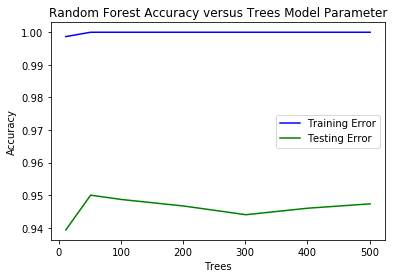

In [13]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

trainAcc = plt.plot(trees, tracc, '-b', label='Training Error')
testACC = plt.plot(trees, tstacc, '-g', label='Testing Error')
plt.title("Random Forest Accuracy versus Trees Model Parameter")
plt.ylabel("Accuracy")
plt.xlabel("Trees")
plt.legend(loc="best")
plt.show(block=False)

### Contingency Tables

#### Let's look at the contingency tables

#### 1) Can you calculate the Sensitivity, Specificity, PPV, NPV? 

In [14]:
model = input("Enter Best Model: ")
best = cont[int(model)]
rf_ct = pd.crosstab(best[1], best[0], margins=True)
rf_ct.columns = ["Other", "PNA", "Total"]
rf_ct.index = ["Other", "PNA", "Total"]
print()
print("Random Forest")
print(rf_ct)
print()


Enter Best Model: 2

Random Forest
       Other  PNA  Total
Other    998   75   1073
PNA        2  425    427
Total   1000  500   1500



### Evaluation Statistics

#### We will calculate some test statistics for our classifiers

In [15]:
Sens = rf_ct.iloc[1][1]/rf_ct.iloc[2][1]
Spec = rf_ct.iloc[0][0]/rf_ct.iloc[2][0]
PPV = rf_ct.iloc[1][1]/rf_ct.iloc[1][2]
NPV = rf_ct.iloc[0][0]/rf_ct.iloc[0][2]
ACC = (rf_ct.iloc[0][0] + rf_ct.iloc[1][1]) / rf_ct.iloc[2][2]
print("Random Forest: Sensitivity: %.5f Specificity: %.5f PPV: %.5f NPV: %.5f Accuracy: %.5f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

Random Forest: Sensitivity: 0.85000 Specificity: 0.99800 PPV: 0.99532 NPV: 0.93010 Accuracy: 0.94867


### ROC Curve

#### 1) So which classifier do you think is better?

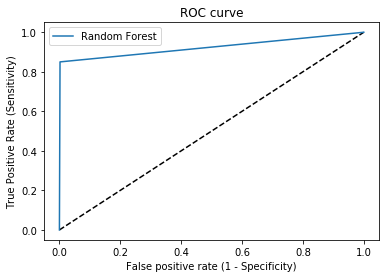

AUC =  0.924


In [16]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(best[0], best[1], pos_label=1)
roc_auc = auc(rf_fpr, rf_tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)